# Introdução

Este *notebook* é o 2º ciclo do CRISP-DM (metodologia de desenvolvimente de projetos de dados) do projeto de classificação de fraude em cartão de crédito.

Neste ciclo, o objetivo é implementar as seguintes melhorias:

- Adicionar técnicas mais avançadas de feature engineering, principalmente baseadas no seguinte artigo: bit.ly/4aYFoQF;
- Melhorar a tunagem de hiperparâmetros anteriormente implementada (adicionar mais hiperparâmetros para serem tunados e o *range* deles);
- Adicionar a tunagem de hiperparâmetros dentro da *cross validation*;
- Testar a performance de um *voting classifier*.

# Configurações Iniciais

## Importando as Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

from sklearn.model_selection import train_test_split, StratifiedKFold

# Importando os modelos
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Encoder para tratamento de variáveis categóricas
from category_encoders import CatBoostEncoder

# Para as pipelines
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Para a seleção de features
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection, RecursiveFeatureElimination

# Para calcular a Precision, Recall, Precision-Recall AUC, ROC AUC, F1-Score e Accuracy
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, f1_score, accuracy_score, confusion_matrix

# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')

# Mostar todas as colunas do dataframe
pd.set_option('display.max_columns', None)

# Usar estilo do ggplot nos gráficos
plt.style.use('ggplot')

## Importando os Dados

In [2]:
data_path = '../fraud.csv'
df = pd.read_csv(data_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [4]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800430e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635330e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


É importante verificar qual a proporção de cada classe presente no _dataset_. Podemos fazer isso com o comando a seguir. É interessante notar, também, que a proporção da classe 1 é o mesmo que a média dessa coluna.

In [5]:
df['is_fraud'].value_counts(1)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# Análise Exploratória de Dados

## Número de Valores Distintos em Cada Coluna

In [7]:
dados_contagem = {'Variável': [], 'Valores Distintos': []}

for coluna in df.columns:
    dados_contagem['Variável'].append(coluna)
    dados_contagem['Valores Distintos'].append(df[coluna].nunique())
    
contagem = pd.DataFrame(dados_contagem)
contagem

,Variável,Valores Distintos
0,Unnamed: 0,555719
1,trans_date_trans_time,226976
2,cc_num,904
3,merchant,693
4,category,14
5,amt,37256
6,first,341
7,last,471
8,gender,2
9,street,924


## Distribuição de Probabilidade dos Valores de Transação

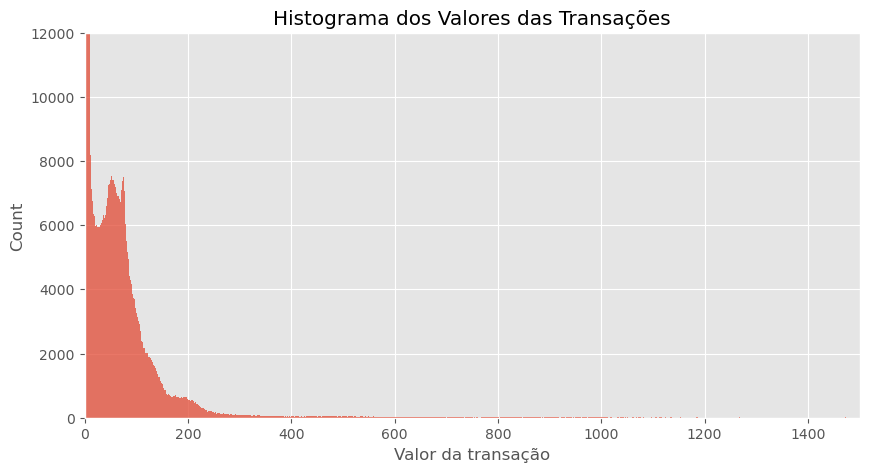

In [8]:
plt.figure(figsize=(10, 5))

sns.histplot(data=df, x='amt')
plt.xlim(0, 1500)
plt.ylim(0, 12000)
plt.title("Histograma dos Valores das Transações")
plt.xlabel("Valor da transação")

plt.show()

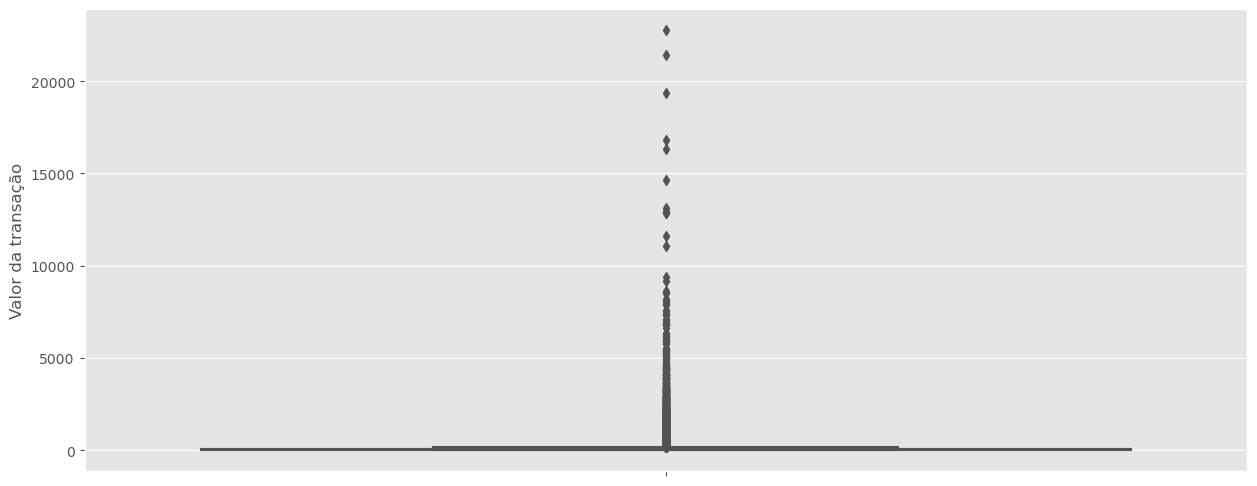

In [9]:
plt.figure(figsize=(15, 6))

sns.boxplot(data=df, y='amt')
plt.ylabel('Valor da transação')

plt.show()

É possível verificar que existem muitos _outliers_ nos dados.

### Distribuições Separadas Pelo _Target_

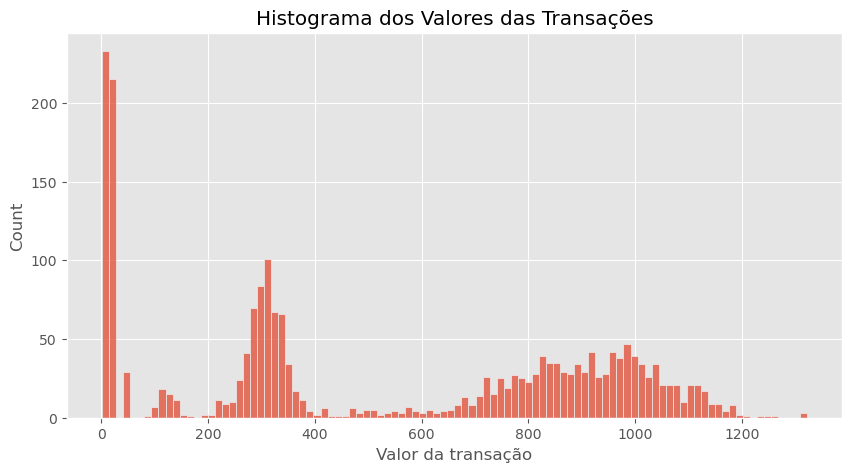

In [10]:
plt.figure(figsize=(10, 5))

sns.histplot(data=df.loc[df['is_fraud'] == 1], x='amt', bins=100)
plt.title("Histograma dos Valores das Transações")
plt.xlabel("Valor da transação")

plt.show()

## Proporção de Homens e Mulheres

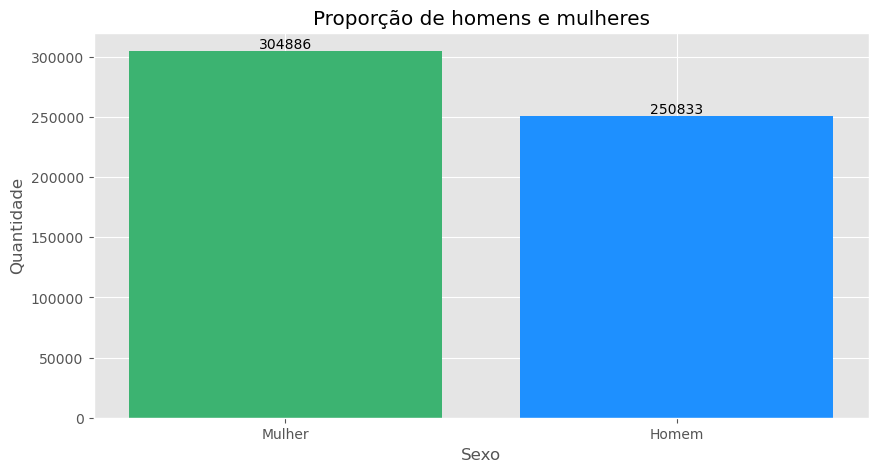

In [11]:
gender_count = df['gender'].value_counts()
index_new = {'M': 'Homem', 'F': 'Mulher'}
gender_count = gender_count.rename(index=index_new)

plt.figure(figsize=(10, 5))

plt.bar(x=gender_count.index, height=gender_count.values, color=['mediumseagreen', 'dodgerblue'])
plt.title("Proporção de homens e mulheres")
plt.xlabel("Sexo")
plt.ylabel("Quantidade")

for i, v in enumerate(gender_count.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

## Categorias das Transações

In [12]:
print(f"Existem {df['category'].nunique()} categorias diferentes de transação no dataframe.")

Existem 14 categorias diferentes de transação no dataframe.


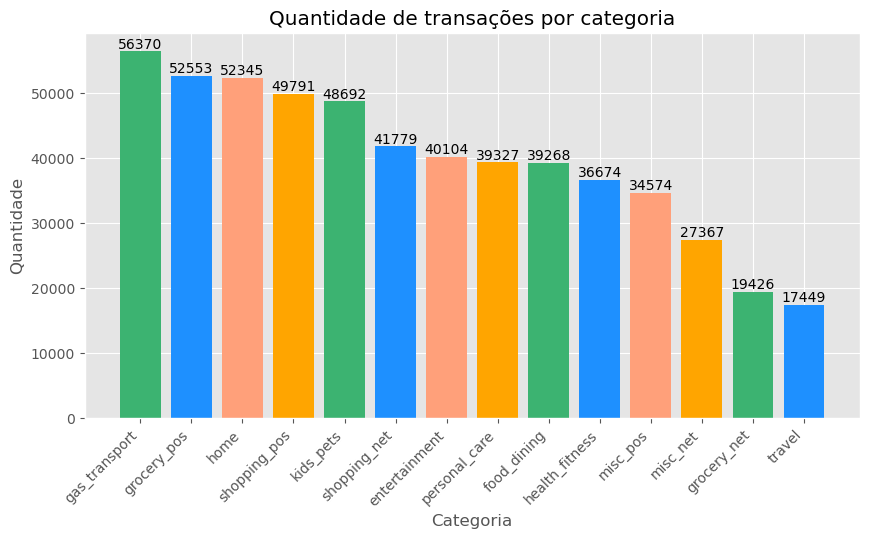

In [13]:
category_count = df['category'].value_counts()

plt.figure(figsize=(10, 5))

plt.bar(x=category_count.index, height=category_count.values, color=['mediumseagreen', 'dodgerblue', 'lightsalmon', 'orange'])
plt.title("Quantidade de transações por categoria")
plt.xlabel("Categoria")
plt.ylabel("Quantidade")
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(category_count.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

## Quantidades em Cada Estado

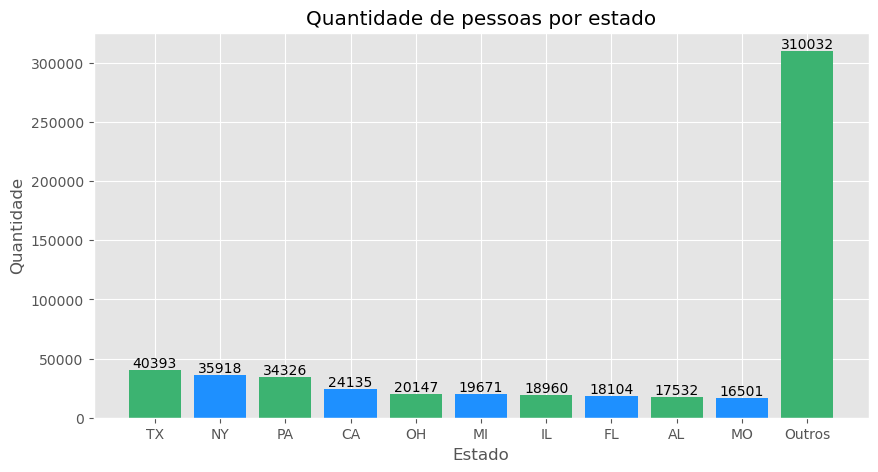

In [14]:
state_count = df['state'].value_counts()
top_10_states = state_count.head(10)
other_states = state_count[~state_count.index.isin(top_10_states.index)].sum()
top_10_states['Outros'] = other_states

plt.figure(figsize=(10, 5))

plt.bar(x=top_10_states.index, height=top_10_states.values, color=['mediumseagreen', 'dodgerblue'])
plt.title("Quantidade de pessoas por estado")
plt.xlabel("Estado")
plt.ylabel("Quantidade")

for i, v in enumerate(top_10_states.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

# Pré-Processamento

In [15]:
df['name'] = df['first'] + ' ' + df['last']
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,name
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,Jeff Elliott
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,Joanne Williams
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,Ashley Lopez
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,Brian Williams
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,Nathan Massey


A variável 'cc_num' (número do cartão) aparece como numérica, mas não queremos que o modelo, porventura, associe um número maior ou menor de cartão à saída do modelo. Além disso, o número do cartão representa, no fim das contas, um objeto. Então, iremos transformar essa coluna em 'object'.

In [16]:
df['cc_num'] = df['cc_num'].astype('object')

# _Feature Engineering_ e _Feature Selection_

## _Mutual Information_

In [17]:
from sklearn.feature_selection import mutual_info_classif

X = df.copy()
y = X.pop('is_fraud')

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Unnamed: 0               2.530215e-02
trans_num                2.530215e-02
unix_time                2.509976e-02
trans_date_trans_time    1.918152e-02
amt                      1.164745e-02
street                   7.743202e-03
name                     7.712927e-03
cc_num                   7.712335e-03
dob                      7.679957e-03
zip                      7.661221e-03
lat                      7.634511e-03
long                     7.493775e-03
city_pop                 7.128510e-03
city                     7.103510e-03
last                     4.172652e-03
job                      4.122954e-03
first                    3.303000e-03
merchant                 2.041518e-03
category                 1.384404e-03
state                    4.536622e-04
merch_lat                2.988484e-04
merch_long               2.646412e-04
gender                   2.791968e-07
Name: MI Scores, dtype: float64

## Adicionando Colunas

Para a _feature engineering_, vamos utilizar a biblioteca Polars. Ela é um equivalente do Pandas, mas um pouco mais otimizada e com alguns metodos mais diretos para agregar dados.

Nós precisaremos dessa eficiência porque vamos criar algumas _features_ que somam dados das últimas 24 horas para cada cartão de crédito, o que pode ser muito demorado com o Pandas em um _dataframe_ com mais de 500000 linhas.

### Nova _Feature_ 1: Idade

In [18]:
from datetime import datetime

df['dob'] = pd.to_datetime(df['dob'], dayfirst = True)
current_date = datetime.now()
df['age'] = (current_date - df['dob']).dt.days // 365

### Nova _Feature_ 2: Quantidade de Transações Últimas 24h

In [19]:
# fraud_with_agg_features_path = '../fraud_with_agg_features.csv'

# new_df = pd.read_csv(fraud_with_agg_features_path)

# df = new_df.copy()

## Selecionando Features

## Colunas Para Remover

Vamos remover algumas colunas que possuem cardinalidade muito alta e/ou que não tenham relação com o _target_.

In [20]:
columns_to_remove = ['Unnamed: 0', 'dob', 'trans_num', 'merch_lat', 'merch_long', 'street', 'first', 'last', 'name', 'trans_date_trans_time', 'state', 'zip', 'lat', 'long', 'city_pop', 'cc_num', 'merchant']

df.drop(columns=columns_to_remove, inplace=True)

# Modelagem Preditiva

## _Class Weights_

In [21]:
weights = df['is_fraud'].value_counts(1)[0] / df['is_fraud'].value_counts(1)[1]
weights_dict = {0: 1, 1: weights}

## Separando _Features_ e _Target_

In [22]:
X = df.drop(columns=['is_fraud'], axis=1)
y = df['is_fraud']

## Dividindo em Treino e Teste

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.head()

# Criando cópias para uso posterior
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [24]:
X_train.head()

,category,amt,gender,city,job,unix_time,age
549254,entertainment,270.96,F,Daly City,"Buyer, industrial",1388360840,32
264995,kids_pets,9.45,M,Marion,Health service manager,1380289125,62
300656,home,110.52,M,Cochranton,Retail merchandiser,1381601155,50
524699,shopping_pos,6.18,M,Oakdale,"Biochemist, clinical",1387949241,71
249815,home,62.78,F,Centerview,Electronics engineer,1379702358,34


In [25]:
# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)
# train.to_csv('../input/train.csv', index=False)
# test.to_csv('../input/test.csv', index=False)

In [26]:
# ##################################
# #### Selecionando as features ####
# ##################################

# # Instanciando cada um dos métodos (retirar as features com baixa variância, retirar features correlacionadas e eliminação recursiva)
# drop_constants = DropConstantFeatures(tol=0.998)
# correlated_sel = SmartCorrelatedSelection(method='pearson', threshold=0.8)
# recursive_elim = RecursiveFeatureElimination(RandomForestClassifier(), scoring='f1', cv=5)

# # Aplicando os métodos aos conjuntos de treino e teste
# X_train = drop_constants.fit_transform(X_train)
# X_test = drop_constants.transform(X_test)

# X_train = correlated_sel.fit_transform(X_train)
# X_test = correlated_sel.transform(X_test)

# X_train = recursive_elim.fit_transform(X_train, y_train)
# X_test = recursive_elim.transform(X_test)

## Pre-Processamento

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 549254 to 216171
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   category   444575 non-null  object 
 1   amt        444575 non-null  float64
 2   gender     444575 non-null  object 
 3   city       444575 non-null  object 
 4   job        444575 non-null  object 
 5   unix_time  444575 non-null  int64  
 6   age        444575 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 27.1+ MB


In [28]:
# Instanciando o onehot encoder para variáveis categóricas
onehot_encoder = OneHotEncoder()

# Instanciando o catboost encoder para variáveis categóricas
catboost_encoder = CatBoostEncoder()

# Instanciando um imputer para variáveis categóricas (preenchimento com a moda)
cat_imputer = SimpleImputer(strategy='most_frequent')

# Instanciando um imputer para variáveis numéricas (preenchimento com a mediana)
num_imputer = SimpleImputer(strategy='median')

# Listando as colunas que são categóricas e as colunas que são numéricas
onehot_columns = pd.Index(['gender', 'category']) # Colunas categoricas que iremos tratar com o onehot encoder
catboost_columns = X_train.select_dtypes(include='object').columns.drop(['gender', 'category']) # Colunas categoricas que iremos tratar com catboost encoder
num_columns = X_train.select_dtypes(exclude='object').columns # Colunas numéricas

onehot_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', onehot_encoder)])
catboost_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', catboost_encoder)])
num_pipeline = Pipeline([('imputer', num_imputer)])

# Criando o transformer que irá aplicar as devidas transformações em cada uma das colunas
transformer = ColumnTransformer([('onehot_transformer', onehot_pipeline, onehot_columns),
                                 ('catboost_transformer', catboost_pipeline, catboost_columns),
                                 ('num_transformer', num_pipeline, num_columns),
                                ], verbose_feature_names_out=False)

# Aplicando o transformer aos dados
X_train_processed = pd.DataFrame(transformer.fit_transform(X_train, y_train))
fn = transformer.get_feature_names_out()
X_test_processed = pd.DataFrame(transformer.transform(X_test))

# Colocando de volta os nomes das colunas, que a aplicação do transformer retirou
X_train_processed.columns = transformer.get_feature_names_out()
X_test_processed.columns = transformer.get_feature_names_out()
X_train_processed.columns, X_test_processed.columns = X_train_processed.columns.astype(str), X_test_processed.columns.astype(str)

## Instanciando os Modelos

In [30]:
xgb_model = XGBClassifier(n_estimators=1000, max_depth = 8, learning_rate = 1e-3, n_jobs =-1, random_state = 0, scale_pos_weight=weights, eval_metric='error')

In [31]:
lgbm_model = LGBMClassifier(n_estimators=1000, max_depth=8, num_leaves=int(2*10e8), learning_rate=1e-3, n_jobs=-1, random_state=0, is_unbalance=True)

In [32]:
catboost_model = CatBoostClassifier(verbose=0)

In [33]:
logistic_regression_model = LogisticRegression(random_state = 0, class_weight='balanced', n_jobs=-1, solver='lbfgs', max_iter=1000)

In [34]:
random_forest_model = RandomForestClassifier(n_estimators=70, max_depth=20, min_samples_split=35, min_samples_leaf=10, class_weight=weights_dict)

In [35]:
voting_lr = LogisticRegression()
voting_dt = DecisionTreeClassifier(max_depth=20, min_samples_split=35, min_samples_leaf=10, class_weight=weights_dict)

voting_model = VotingClassifier([('voting_lr', voting_lr),
                                 ('voting_dt', voting_dt)
                                ], voting='soft')

## Criando o Algoritmo de Validação Cruzada

In [36]:
def cross_validation(X_train, y_train, model, k, threshold):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    train_accuracies = list()
    train_precisions = list()
    train_recalls = list()
    train_f1_scores = list()
    train_precision_recall_aucs = list()
    train_roc_aucs = list()

    accuracies = list()
    precisions = list()
    recalls = list()
    f1_scores = list()
    precision_recall_aucs = list()
    roc_aucs = list()

    for k, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):
        # Exibindo qual a pasta atual
        print("=-"*6 + f"Fold: {k+1}" + "-="*6)
        print()

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_cv, y_train_cv = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_test_cv, y_test_cv = X_train.iloc[test_index, :], y_train.iloc[test_index]

        # Treinando o modelo
        model.fit(X_train_cv, y_train_cv)
        
        #################################################
        #### Avaliando Predições nos Dados de Treino ####
        #################################################

        # Obtendo as probabilidades de cada instância pertencer a classe 1
        train_y_pred_proba = model.predict_proba(X_train_cv)[:, 1]

        # Obtendo as classes preditas, de acordo com o threshold estabelecido
        train_y_pred = np.where(train_y_pred_proba > threshold, 1, 0)

        # Calculando a accuracy
        train_accuracy = accuracy_score(y_train_cv, train_y_pred)

        # Calculando a precision
        train_precision_score_result = precision_score(y_train_cv, train_y_pred)

        # Calculando a recall
        train_recall_score_result = recall_score(y_train_cv, train_y_pred)

        # Calculando a precision e a recall para calcular a PR AUC
        train_precision, train_recall, train_thresholds = precision_recall_curve(y_train_cv, train_y_pred)

        # Calculando o F1-Score
        train_f1 = f1_score(y_train_cv, train_y_pred)

        # Calculando a PR AUC
        train_pr_auc = auc(train_precision, train_recall)

        # Calculando a ROC AUC
        train_roc_auc = roc_auc_score(y_train_cv, train_y_pred_proba)

        # Adicionando cada uma das métricas na sua respectiva lista, para depois tirar a média
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision_score_result)
        train_recalls.append(train_recall_score_result)
        train_f1_scores.append(train_f1)
        train_precision_recall_aucs.append(train_pr_auc)
        train_roc_aucs.append(train_roc_auc)

        # Exibindo as métricas para cada um dos folds
        print("=-"*3 + f"Treino" + "-="*3)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision_score_result:.4f}")
        print(f"Train Recall: {train_recall_score_result:.4f}")
        print(f"Train F1-Score: {train_f1:.4f}")
        print(f"Train Precision-Recall AUC: {train_pr_auc:.4f}")
        print(f"Train ROC AUC: {train_roc_auc:.4f}")
        print()

        ################################################
        #### Avaliando Predições nos Dados de Teste ####
        ################################################

        # Obtendo as probabilidades de cada instância pertencer a classe 1
        y_pred_proba = model.predict_proba(X_test_cv)[:, 1]

        # Obtendo as classes preditas, de acordo com o threshold estabelecido
        y_pred = np.where(y_pred_proba > threshold, 1, 0)

        # Calculando a accuracy
        accuracy = accuracy_score(y_test_cv, y_pred)

        # Calculando a precision
        precision_score_result = precision_score(y_test_cv, y_pred)

        # Calculando a recall
        recall_score_result = recall_score(y_test_cv, y_pred)

        # Calculando a precision e a recall para calcular a PR AUC
        precision, recall, thresholds = precision_recall_curve(y_test_cv, y_pred)

        # Calculando o F1-Score
        f1 = f1_score(y_test_cv, y_pred)

        # Calculando a PR AUC
        pr_auc = auc(precision, recall)

        # Calculando a ROC AUC
        roc_auc = roc_auc_score(y_test_cv, y_pred_proba)

        # Adicionando cada uma das métricas na sua respectiva lista, para depois tirar a média
        accuracies.append(accuracy)
        precisions.append(precision_score_result)
        recalls.append(recall_score_result)
        f1_scores.append(f1)
        precision_recall_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)

        # Exibindo as métricas para cada um dos folds
        print("=-"*3 + f"Teste" + "-="*3)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision_score_result:.4f}")
        print(f"Test Recall: {recall_score_result:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print(f"Test Precision-Recall AUC: {pr_auc:.4f}")
        print(f"Test ROC AUC: {roc_auc:.4f}")
        print()

    # Transformando as listas de métricas em um array do numpy

    # Treino
    train_accuracies = np.array(train_accuracies)
    train_precisions = np.array(train_precisions)
    train_recalls = np.array(train_recalls)
    train_f1_scores = np.array(train_f1_scores)
    train_precision_recall_aucs = np.array(train_precision_recall_aucs)
    train_roc_aucs = np.array(train_roc_aucs)

    # Teste
    accuracies = np.array(accuracies)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)
    precision_recall_aucs = np.array(precision_recall_aucs)
    roc_aucs = np.array(roc_aucs)

    # Calculando as médias das métricas

    # Treino
    train_accuracies_mean = np.mean(train_accuracies)
    train_precisions_mean = np.mean(train_precisions)
    train_recalls_mean = np.mean(train_recalls)
    train_f1_scores_mean = np.mean(train_f1_scores)
    train_precision_recall_aucs_mean = np.mean(train_precision_recall_aucs)
    train_roc_aucs_mean = np.mean(train_roc_aucs)
    
    # Teste
    accuracies_mean = np.mean(accuracies)
    precisions_mean = np.mean(precisions)
    recalls_mean = np.mean(recalls)
    f1_scores_mean = np.mean(f1_scores)
    precision_recall_aucs_mean = np.mean(precision_recall_aucs)
    roc_aucs_mean = np.mean(roc_aucs)

    # Calculando os desvios padrão das métricas

    # Treino
    train_accuracies_std = np.std(train_accuracies)
    train_precisions_std = np.std(train_precisions)
    train_recalls_std = np.std(train_recalls)
    train_f1_scores_std = np.std(train_f1_scores)
    train_precision_recall_aucs_std = np.std(train_precision_recall_aucs)
    train_roc_aucs_std = np.std(train_roc_aucs)
    
    # Teste
    accuracies_std = np.std(accuracies)
    precisions_std = np.std(precisions)
    recalls_std = np.std(recalls)
    f1_scores_std = np.std(f1_scores)
    precision_recall_aucs_std = np.std(precision_recall_aucs)
    roc_aucs_std = np.std(roc_aucs)

    # Exibindo as médias e desvios padrão
    
    print()
    print("=-"*6 + "Exibindo a média das métricas obtidas" + "-="*6)
    print()
    
    # Treino
    print("=-"*6 + "Treino" + "-="*6)
    print(f"Train Accuracy mean: {train_accuracies_mean:.4f} +/- {train_accuracies_std:.4f}")
    print(f"Train Precision mean: {train_precisions_mean:.4f} +/- {train_precisions_std:.4f}")
    print(f"Train Recall mean: {train_recalls_mean:.4f} +/- {train_recalls_std:.4f}")
    print(f"Train F1-Score mean: {train_f1_scores_mean:.4f} +/- {train_f1_scores_std:.4f}")
    print(f"Train PR AUC mean: {train_precision_recall_aucs_mean:.4f} +/- {train_precision_recall_aucs_std:.4f}")
    print(f"Train ROC AUC mean: {train_roc_aucs_mean:.4f} +/- {train_roc_aucs_std:.4f}")
    print()

    # Teste
    print("=-"*6 + "Teste" + "-="*6)
    print(f"Test Accuracy mean: {accuracies_mean:.4f} +/- {accuracies_std:.4f}")
    print(f"Test Precision mean: {precisions_mean:.4f} +/- {precisions_std:.4f}")
    print(f"Test Recall mean: {recalls_mean:.4f} +/- {recalls_std:.4f}")
    print(f"Test F1-Score mean: {f1_scores_mean:.4f} +/- {f1_scores_std:.4f}")
    print(f"Test PR AUC mean: {precision_recall_aucs_mean:.4f} +/- {precision_recall_aucs_std:.4f}")
    print(f"Test ROC AUC mean: {roc_aucs_mean:.4f} +/- {roc_aucs_std:.4f}")

In [37]:
def cross_validation_voting(X_train, y_train, model, k):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    train_accuracies = list()
    train_precisions = list()
    train_recalls = list()
    train_f1_scores = list()
    train_precision_recall_aucs = list()
    train_roc_aucs = list()

    accuracies = list()
    precisions = list()
    recalls = list()
    f1_scores = list()
    precision_recall_aucs = list()
    roc_aucs = list()

    for k, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):
        # Exibindo qual a pasta atual
        print("=-"*6 + f"Fold: {k+1}" + "-="*6)
        print()

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_cv, y_train_cv = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_test_cv, y_test_cv = X_train.iloc[test_index, :], y_train.iloc[test_index]

        # Treinando o modelo
        model.fit(X_train_cv, y_train_cv)
        
        #################################################
        #### Avaliando Predições nos Dados de Treino ####
        #################################################

        # Obtendo as classes
        train_y_pred = model.predict(X_train_cv)

        # Calculando a accuracy
        train_accuracy = accuracy_score(y_train_cv, train_y_pred)

        # Calculando a precision
        train_precision_score_result = precision_score(y_train_cv, train_y_pred)

        # Calculando a recall
        train_recall_score_result = recall_score(y_train_cv, train_y_pred)

        # Calculando a precision e a recall para calcular a PR AUC
        train_precision, train_recall, train_thresholds = precision_recall_curve(y_train_cv, train_y_pred)

        # Calculando o F1-Score
        train_f1 = f1_score(y_train_cv, train_y_pred)

        # Calculando a PR AUC
        train_pr_auc = auc(train_precision, train_recall)

        # Calculando a ROC AUC
        train_roc_auc = roc_auc_score(y_train_cv, train_y_pred)

        # Adicionando cada uma das métricas na sua respectiva lista, para depois tirar a média
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision_score_result)
        train_recalls.append(train_recall_score_result)
        train_f1_scores.append(train_f1)
        train_precision_recall_aucs.append(train_pr_auc)
        train_roc_aucs.append(train_roc_auc)

        # Exibindo as métricas para cada um dos folds
        print("=-"*3 + f"Treino" + "-="*3)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision_score_result:.4f}")
        print(f"Train Recall: {train_recall_score_result:.4f}")
        print(f"Train F1-Score: {train_f1:.4f}")
        print(f"Train Precision-Recall AUC: {train_pr_auc:.4f}")
        print(f"Train ROC AUC: {train_roc_auc:.4f}")
        print()

        ################################################
        #### Avaliando Predições nos Dados de Teste ####
        ################################################

        # Obtendo as classes
        y_pred = model.predict(X_test_cv)

        # Calculando a accuracy
        accuracy = accuracy_score(y_test_cv, y_pred)

        # Calculando a precision
        precision_score_result = precision_score(y_test_cv, y_pred)

        # Calculando a recall
        recall_score_result = recall_score(y_test_cv, y_pred)

        # Calculando a precision e a recall para calcular a PR AUC
        precision, recall, thresholds = precision_recall_curve(y_test_cv, y_pred)

        # Calculando o F1-Score
        f1 = f1_score(y_test_cv, y_pred)

        # Calculando a PR AUC
        pr_auc = auc(precision, recall)

        # Calculando a ROC AUC
        roc_auc = roc_auc_score(y_test_cv, y_pred)

        # Adicionando cada uma das métricas na sua respectiva lista, para depois tirar a média
        accuracies.append(accuracy)
        precisions.append(precision_score_result)
        recalls.append(recall_score_result)
        f1_scores.append(f1)
        precision_recall_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)

        # Exibindo as métricas para cada um dos folds
        print("=-"*3 + f"Teste" + "-="*3)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision_score_result:.4f}")
        print(f"Test Recall: {recall_score_result:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print(f"Test Precision-Recall AUC: {pr_auc:.4f}")
        print(f"Test ROC AUC: {roc_auc:.4f}")
        print()

    # Transformando as listas de métricas em um array do numpy

    # Treino
    train_accuracies = np.array(train_accuracies)
    train_precisions = np.array(train_precisions)
    train_recalls = np.array(train_recalls)
    train_f1_scores = np.array(train_f1_scores)
    train_precision_recall_aucs = np.array(train_precision_recall_aucs)
    train_roc_aucs = np.array(train_roc_aucs)

    # Teste
    accuracies = np.array(accuracies)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)
    precision_recall_aucs = np.array(precision_recall_aucs)
    roc_aucs = np.array(roc_aucs)

    # Calculando as médias das métricas

    # Treino
    train_accuracies_mean = np.mean(train_accuracies)
    train_precisions_mean = np.mean(train_precisions)
    train_recalls_mean = np.mean(train_recalls)
    train_f1_scores_mean = np.mean(train_f1_scores)
    train_precision_recall_aucs_mean = np.mean(train_precision_recall_aucs)
    train_roc_aucs_mean = np.mean(train_roc_aucs)
    
    # Teste
    accuracies_mean = np.mean(accuracies)
    precisions_mean = np.mean(precisions)
    recalls_mean = np.mean(recalls)
    f1_scores_mean = np.mean(f1_scores)
    precision_recall_aucs_mean = np.mean(precision_recall_aucs)
    roc_aucs_mean = np.mean(roc_aucs)

    # Calculando os desvios padrão das métricas

    # Treino
    train_accuracies_std = np.std(train_accuracies)
    train_precisions_std = np.std(train_precisions)
    train_recalls_std = np.std(train_recalls)
    train_f1_scores_std = np.std(train_f1_scores)
    train_precision_recall_aucs_std = np.std(train_precision_recall_aucs)
    train_roc_aucs_std = np.std(train_roc_aucs)
    
    # Teste
    accuracies_std = np.std(accuracies)
    precisions_std = np.std(precisions)
    recalls_std = np.std(recalls)
    f1_scores_std = np.std(f1_scores)
    precision_recall_aucs_std = np.std(precision_recall_aucs)
    roc_aucs_std = np.std(roc_aucs)

    # Exibindo as médias e desvios padrão
    
    print()
    print("=-"*6 + "Exibindo a média das métricas obtidas" + "-="*6)
    print()
    
    # Treino
    print("=-"*6 + "Treino" + "-="*6)
    print(f"Train Accuracy mean: {train_accuracies_mean:.4f} +/- {train_accuracies_std:.4f}")
    print(f"Train Precision mean: {train_precisions_mean:.4f} +/- {train_precisions_std:.4f}")
    print(f"Train Recall mean: {train_recalls_mean:.4f} +/- {train_recalls_std:.4f}")
    print(f"Train F1-Score mean: {train_f1_scores_mean:.4f} +/- {train_f1_scores_std:.4f}")
    print(f"Train PR AUC mean: {train_precision_recall_aucs_mean:.4f} +/- {train_precision_recall_aucs_std:.4f}")
    print(f"Train ROC AUC mean: {train_roc_aucs_mean:.4f} +/- {train_roc_aucs_std:.4f}")
    print()

    # Teste
    print("=-"*6 + "Teste" + "-="*6)
    print(f"Test Accuracy mean: {accuracies_mean:.4f} +/- {accuracies_std:.4f}")
    print(f"Test Precision mean: {precisions_mean:.4f} +/- {precisions_std:.4f}")
    print(f"Test Recall mean: {recalls_mean:.4f} +/- {recalls_std:.4f}")
    print(f"Test F1-Score mean: {f1_scores_mean:.4f} +/- {f1_scores_std:.4f}")
    print(f"Test PR AUC mean: {precision_recall_aucs_mean:.4f} +/- {precision_recall_aucs_std:.4f}")
    print(f"Test ROC AUC mean: {roc_aucs_mean:.4f} +/- {roc_aucs_std:.4f}")

## XGBoost

In [38]:
# cross_validation(X_train_processed, y_train, xgb_model, 5, 0.8)

## LightGBM

In [39]:
# cross_validation(X_train_processed, y_train, lgbm_model, 5, 0.5)

## CatBoost

In [40]:
# cross_validation(X_train_processed, y_train, catboost_model, 5, 0.5)

## _Random Forest Classifier_

In [41]:
cross_validation(X_train_processed, y_train, random_forest_model, 5, 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9958
Train Precision: 0.4797
Train Recall: 0.9971
Train F1-Score: 0.6477
Train Precision-Recall AUC: 0.7345
Train ROC AUC: 0.9997

=-=-=-Teste-=-=-=
Test Accuracy: 0.9950
Test Precision: 0.4288
Test Recall: 0.8776
Test F1-Score: 0.5761
Test Precision-Recall AUC: 0.6495
Test ROC AUC: 0.9936

=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9958
Train Precision: 0.4819
Train Recall: 1.0000
Train F1-Score: 0.6504
Train Precision-Recall AUC: 0.7371
Train ROC AUC: 0.9997

=-=-=-Teste-=-=-=
Test Accuracy: 0.9953
Test Precision: 0.4433
Test Recall: 0.8776
Test F1-Score: 0.5890
Test Precision-Recall AUC: 0.6568
Test ROC AUC: 0.9918

=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9958
Train Precision: 0.4789
Train Recall: 0.9993
Train F1-Score: 0.6475
Train Precision-Recall AUC: 0.7352
Train ROC AUC: 0.9997

=-=-=-Teste-=-=-=
Test Accuracy: 0.9953
Test Precision: 0.4468
Test Recall:

## _Voting Classifier_

In [42]:
cross_validation(X_train_processed, y_train, voting_model, 5, 0.5)

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9985
Train Precision: 0.8592
Train Recall: 0.7291
Train F1-Score: 0.7888
Train Precision-Recall AUC: 0.7908
Train ROC AUC: 0.9992

=-=-=-Teste-=-=-=
Test Accuracy: 0.9982
Test Precision: 0.8110
Test Recall: 0.6880
Test F1-Score: 0.7445
Test Precision-Recall AUC: 0.7463
Test ROC AUC: 0.9501

=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9985
Train Precision: 0.8726
Train Recall: 0.7036
Train F1-Score: 0.7790
Train Precision-Recall AUC: 0.7848
Train ROC AUC: 0.9992

=-=-=-Teste-=-=-=
Test Accuracy: 0.9983
Test Precision: 0.8615
Test Recall: 0.6531
Test F1-Score: 0.7430
Test Precision-Recall AUC: 0.7541
Test ROC AUC: 0.9522

=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=

=-=-=-Treino-=-=-=
Train Accuracy: 0.9985
Train Precision: 0.8821
Train Recall: 0.7138
Train F1-Score: 0.7890
Train Precision-Recall AUC: 0.7946
Train ROC AUC: 0.9991

=-=-=-Teste-=-=-=
Test Accuracy: 0.9982
Test Precision: 0.8327
Test Recall:

## Modelo Final Utilizado

In [43]:
# Definindo o threshold
threshold = 0.5

# Instanciando o modelo
model = voting_model

# Treinando o modelo
model.fit(X_train_processed, y_train)

#################################################
#### Avaliando Predições nos Dados de Treino ####
#################################################

# Obtendo as probabilidades de cada instância pertencer a classe 1
train_y_pred_proba = model.predict_proba(X_train_processed)[:, 1]

# Obtendo as classes preditas, de acordo com o threshold estabelecido
train_y_pred = np.where(train_y_pred_proba > threshold, 1, 0)

# Calculando a accuracy
train_accuracy = accuracy_score(y_train, train_y_pred)

# Calculando a precision
train_precision_score_result = precision_score(y_train, train_y_pred)

# Calculando a recall
train_recall_score_result = recall_score(y_train, train_y_pred)

# Calculando a precision e a recall para calcular a PR AUC
train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, train_y_pred)

# Calculando o F1-Score
train_f1 = f1_score(y_train, train_y_pred)

# Calculando a PR AUC
train_pr_auc = auc(train_precision, train_recall)

# Calculando a ROC AUC
train_roc_auc = roc_auc_score(y_train, train_y_pred_proba)

# Exibindo as métricas
print("=-"*3 + f"Treino" + "-="*3)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision_score_result:.4f}")
print(f"Train Recall: {train_recall_score_result:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Train Precision-Recall AUC: {train_pr_auc:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print()

################################################
#### Avaliando Predições nos Dados de Teste ####
################################################

# Obtendo as probabilidades de cada instância pertencer a classe 1
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

# Obtendo as classes preditas, de acordo com o threshold estabelecido
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Calculando a accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculando a precision
precision_score_result = precision_score(y_test, y_pred)

# Calculando a recall
recall_score_result = recall_score(y_test, y_pred)

# Calculando a precision e a recall para calcular a PR AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculando o F1-Score
f1 = f1_score(y_test, y_pred)

# Calculando a PR AUC
pr_auc = auc(precision, recall)

# Calculando a ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Exibindo as métricas
print("=-"*3 + f"Teste" + "-="*3)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision_score_result:.4f}")
print(f"Test Recall: {recall_score_result:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test Precision-Recall AUC: {pr_auc:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print()

=-=-=-Treino-=-=-=
Train Accuracy: 0.9985
Train Precision: 0.8843
Train Recall: 0.7174
Train F1-Score: 0.7921
Train Precision-Recall AUC: 0.7975
Train ROC AUC: 0.9992

=-=-=-Teste-=-=-=
Test Accuracy: 0.9986
Test Precision: 0.8753
Test Recall: 0.7366
Test F1-Score: 0.8000
Test Precision-Recall AUC: 0.8026
Test ROC AUC: 0.9726



# Tunagem de Hiperparâmetros

In [44]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# f1_scorer = make_scorer(f1_score)

# def objective(trial):
    
#     # Definindo o espaço de busca dos hiperparâmetros
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_depth = trial.suggest_int('max_depth', 1, 40)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 40)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100)
    
#     # Criando, treinando e retornando o resultado do modelo
#     model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42, n_jobs=-1)
#     score = cross_val_score(estimator=model, X=X_train_processed, y=y_train, n_jobs=-1, cv=3, scoring='roc_auc').mean()
    
#     return score

# # Criando o estudo do Optuna e buscando os melhores parâmetros
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=32)

# # Melhores hiperpaâmetros encontrados
# best_params = study.best_params
# print(best_params)

In [45]:
# # Instanciando o modelo final
# final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

# # Treinando o modelo final
# final_model.fit(X_train_processed, y_train)

# #################################################
# #### Avaliando Predições nos Dados de Treino ####
# #################################################

# # Obtendo as probabilidades de cada instância pertencer a classe 1
# train_y_pred_proba = final_model.predict_proba(X_train_processed)[:, 1]

# # Obtendo as classes preditas, de acordo com o threshold estabelecido
# train_y_pred = np.where(train_y_pred_proba > threshold, 1, 0)

# # Calculando a accuracy
# train_accuracy = accuracy_score(y_train, train_y_pred)

# # Calculando a precision
# train_precision_score_result = precision_score(y_train, train_y_pred)

# # Calculando a recall
# train_recall_score_result = recall_score(y_train, train_y_pred)

# # Calculando a precision e a recall para calcular a PR AUC
# train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, train_y_pred)

# # Calculando o F1-Score
# train_f1 = f1_score(y_train, train_y_pred)

# # Calculando a PR AUC
# train_pr_auc = auc(train_precision, train_recall)

# # Calculando a ROC AUC
# train_roc_auc = roc_auc_score(y_train, train_y_pred_proba)

# # Exibindo as métricas
# print("=-"*3 + f"Treino" + "-="*3)
# print(f"Train Accuracy: {train_accuracy:.4f}")
# print(f"Train Precision: {train_precision_score_result:.4f}")
# print(f"Train Recall: {train_recall_score_result:.4f}")
# print(f"Train F1-Score: {train_f1:.4f}")
# print(f"Train Precision-Recall AUC: {train_pr_auc:.4f}")
# print(f"Train ROC AUC: {train_roc_auc:.4f}")
# print()

# ################################################
# #### Avaliando Predições nos Dados de Teste ####
# ################################################

# y_pred_proba = final_model.predict_proba(X_test_processed)[:, 1]
# y_pred = np.where(y_pred_proba > threshold, 1, 0)

# # Calculando a accuracy
# accuracy = accuracy_score(y_test, y_pred)

# # Calculando a precision
# precision_score_result = precision_score(y_test, y_pred)

# # Calculando a recall
# recall_score_result = recall_score(y_test, y_pred)

# # Calculando a precision e a recall para calcular a PR AUC
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# # Calculando o F1-Score
# f1 = f1_score(y_test, y_pred)

# # Calculando a PR AUC
# pr_auc = auc(precision, recall)

# # Calculando a ROC AUC
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print("=-"*3 + f"Teste" + "-="*3)
# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test Precision: {precision_score_result:.4f}")
# print(f"Test Recall: {recall_score_result:.4f}")
# print(f"Test F1-Score: {f1:.4f}")
# print(f"Test Precision-Recall AUC: {pr_auc:.4f}")
# print(f"Test ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão

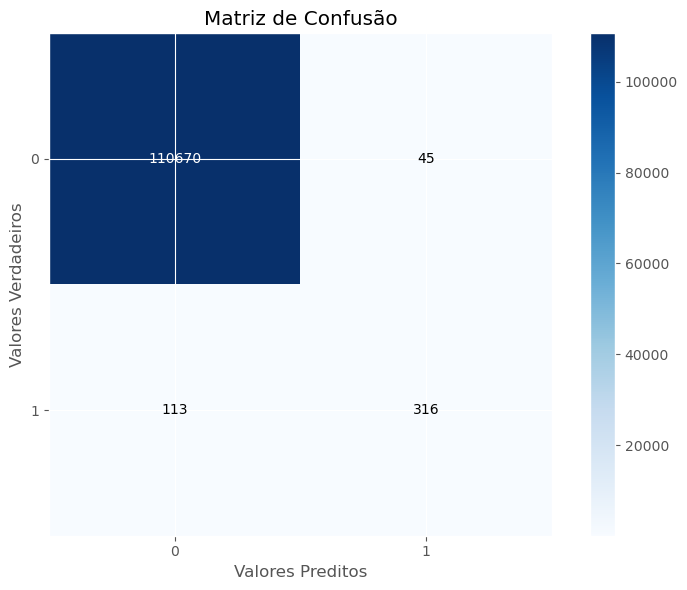

In [46]:
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_pred)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.tight_layout()
plt.show()

In [47]:
336 / 93

3.6129032258064515

# Feature Importance

Aqui, podemos verificar o quanto cada feature está sendo usada pelo nosso modelo nos ramos das nossas árvores de decisão, através do feature importance.

In [48]:
importances = model.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train_processed.columns)[indices])

AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

# Análise de Negócio

## Era Fraude e Acertou

In [49]:
y_pred = pd.Series(y_pred)
hits = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['is_fraud'] == y_pred]
is_fraud_indices = hits[hits == 1].index
X_test_copy_2 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[is_fraud_indices, :]

In [50]:
total_transactions = (X_test_copy_2['amt'].values).sum()
print(f"O valor total que foi evitado de ser perdido em fraudes foi de: $ {total_transactions:.2f}")

O valor total que foi evitado de ser perdido em fraudes foi de: $ 195505.92


## Era Fraude e Errou

In [52]:
y_pred = pd.Series(y_pred)

# Procurando todos os casos em que o y_pred é diferente do y_test
not_hits = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['is_fraud'] != y_pred]

# Indices dos que eram fraude e o modelo previu como não sendo
was_fraud_indices = not_hits[not_hits == 0].index

# Pegando todas as instâncias que possuem o indices calculados anteriormente
X_test_copy_2 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[was_fraud_indices, :]

In [53]:
total_fraud_transactions = (X_test_copy_2['amt'].values).sum()
print(f"O valor total que foi fraudado e o modelo não captou foi de: $ {total_fraud_transactions:.2f}")

O valor total que foi fraudado e o modelo não captou foi de: $ 26850.17


Desse modo, é possível afirmar que o nosso modelo evitou um prejuízo de 195505,92, enquanto deixou passar 26850,17.

Podemos perceber que evitamos um montante em fraudes parecido com o do nosso modelo anterior (versão 1 do projeto), mas sem precisar, para isso, gerar tantos falsos positivos. Portanto, houve uma melhora nos resultados ao utilizarmos o _voting classifier_.